In [2]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.utils import random_choose_candidate_2
from src.pipette_scheduler import calculate_D, calculate_S_E, calculate_D_prime,calculate_T
from src.optimization_methods import row_wise_optimization, greedy_scheduling
import pandas as pd

/home/yq-mew/yq/chem1906/Projects/pipette_scheduling


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def calculate_T_test(sequences):
    # the matrix should be paddled with -1, return a n*n matrix
    # sequences is a n*8 matrix
    # which job are next to each other
    sequences_flat = sequences.flatten()
    sequences_flat = sequences_flat[sequences_flat != -1]
    
    zeros = np.zeros((sequences_flat.shape[0]+1,sequences_flat.shape[0]+1))
    for sequence in sequences:
        # link the depot with the first job in a cycle
        zeros[0,sequence[0]] = 1
        for i in range(sequence.shape[0]-1):
            if sequence[i] != -1 and sequence[i+1] != -1:
                zeros[sequence[i],sequence[i+1]] = 1
            else:
                # link the last job with the depot in a cycle
                zeros[sequence[i],0] = 1
                break
    return zeros

In [4]:
labware_list =[12,24,96,384]
# enumerate all the two combinations of the labware_list
labware_combinations = []
for i in range(len(labware_list)):
    for j in range(len(labware_list)):
        labware_combinations.append([labware_list[i], labware_list[j]])
#labware_combinations.append([1536,1536])
#labware_combinations

In [5]:
# establish an empty dataframe to store the results
df = pd.DataFrame(columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])

In [ ]:
np.random.seed(0)
for labware_combination in labware_combinations: 

    source_dim = labware_combination[0]
    dest_dim = labware_combination[1]
    print(f'source_dim={source_dim}, dest_dim={dest_dim}')
    for r in range(1):
        print('repeat:',r+1)
        stats = []
        for i in range(1, 11):

            num_candidates = dest_dim * i -5
            num_candidates = int(num_candidates)
            print(f'num_candidates={num_candidates}')
            a = random_choose_candidate_2(source_dim,dest_dim,num_candidates)
            #a[a>0] = 1
            jobs = np.argwhere(a)
            D_S = calculate_D(a.shape[0])
            D_D = calculate_D(a.shape[1])
            S, E, volumes = calculate_S_E(a)
            # calculate distance matrix
            D_prime = calculate_D_prime(D_S, D_D, S, E, volumes, 1, 100, 1, 100)
            # VRP solver
            VRP_distance, VRP_recorder = CVRP_solver((D_prime * 100).astype(np.int64), solving_time=20)
            VRP_distance = VRP_distance / 100
            print(f'VRP_distance: {VRP_distance}')
            # calculate the cost of the non-optimized sequence
            tasks = np.array(range(jobs.shape[0]))
            tasks = tasks+1
            # if tasks.shape[0] %8 != 0, pad with -1
            if tasks.shape[0] %8 != 0:
                tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
            unoptimized_seuqnece = tasks.reshape(-1, 8)
            t = calculate_T_test(unoptimized_seuqnece)
            d = D_prime
            non_optimized_distance = np.trace(np.dot(t.T, d))
            # change non_optimized_distance to integer
            non_optimized_distance = int(non_optimized_distance)
            print(f'non_optimized_distance: {non_optimized_distance}')
            
            # calculate the cost of the row-wise optimized sequence
            index_matrix = np.zeros((source_dim,dest_dim))
            for j in range(jobs.shape[0]):
                index_matrix[jobs[j, 0], jobs[j, 1]] = j+1
            row_wise_optimized_sequence = row_wise_optimization(index_matrix)
            if row_wise_optimized_sequence.shape[0] %8 != 0:
                row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
            t = calculate_T_test(row_wise_optimized_sequence)
            row_wise_optimized_distance = np.trace(np.dot(t.T, d))
            # change non_optimized_distance to integer
            row_wise_optimized_distance = int(row_wise_optimized_distance)
            print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

            # calculate the cost of the greedy optimized sequence
            greedy_optimized_sequence = greedy_scheduling(jobs, d)
            if greedy_optimized_sequence.shape[0] %8 != 0:
                greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
            t = calculate_T_test(greedy_optimized_sequence)
            greedy_optimized_distance = np.trace(np.dot(t.T, d))
            print(f'greedy_optimized_distance: {greedy_optimized_distance}')
            # append the results to the df
            stats.append([source_dim, dest_dim, num_candidates, r+1, non_optimized_distance, row_wise_optimized_distance, greedy_optimized_distance, VRP_distance])
        # convert the stats to the dataframe
        stats = pd.DataFrame(stats, columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])
        # append the stats to the df
        df = pd.concat([df, stats], ignore_index=True)
        print(df)


source_dim=12, dest_dim=12
repeat: 1
num_candidates=7
VRP_distance: 17.0
non_optimized_distance: 18
row_wise_optimized_distance: 18
greedy_optimized_distance: 19.72
num_candidates=19
VRP_distance: 33.51
non_optimized_distance: 43
row_wise_optimized_distance: 41
greedy_optimized_distance: 45.8
num_candidates=31
VRP_distance: 65.32
non_optimized_distance: 76
row_wise_optimized_distance: 76
greedy_optimized_distance: 80.07000000000001
num_candidates=43
VRP_distance: 73.62
non_optimized_distance: 109
row_wise_optimized_distance: 95
greedy_optimized_distance: 114.93
num_candidates=55
VRP_distance: 96.07
non_optimized_distance: 149
row_wise_optimized_distance: 123
greedy_optimized_distance: 160.05
num_candidates=67


In [ ]:
df.to_csv('grid_search.csv', index=False)

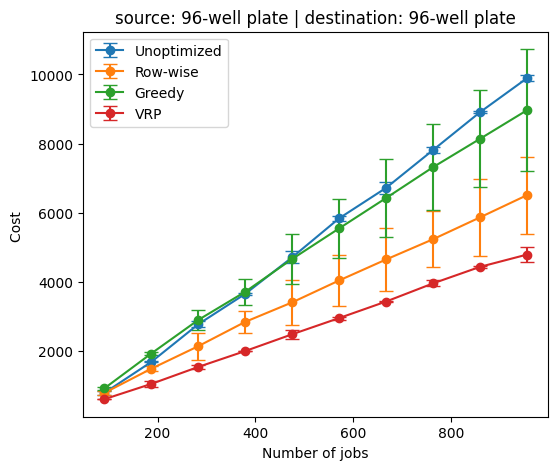

In [13]:
for labware_combination in labware_combinations: 
    source = labware_combination[0]
    dest = labware_combination[1]
    df_choosen = df[(df['source_labware'] == source) & (df['dest_labware'] == dest)]
    # compute the mean and std of the unoptimized, rowwise, greedy and VRP
    df_choosen_mean = df_choosen.groupby(['num_samples']).mean().reset_index()
    df_choosen_std = df_choosen.groupby(['num_samples']).std().reset_index()
    # plot the results
    plt.figure(figsize=(6, 5))
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['unoptimized'], yerr=df_choosen_std['unoptimized'], label='Unoptimized', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['rowwise'], yerr=df_choosen_std['rowwise'], label='Row-wise', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['greedy'], yerr=df_choosen_std['greedy'], label='Greedy', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['VRP'], yerr=df_choosen_std['VRP'], label='VRP', fmt='o-', capsize=5)
    plt.title(f'source: {source}-well plate | destination: {dest}-well plate')
    plt.xlabel('Number of jobs')
    plt.ylabel('Cost ')
    plt.legend()
    plt.show()

In [4]:
# read the csv file
df = pd.read_csv('/u/yq/chem1906/Projects/pipette_scheduling/results/results_different_labwares.csv')

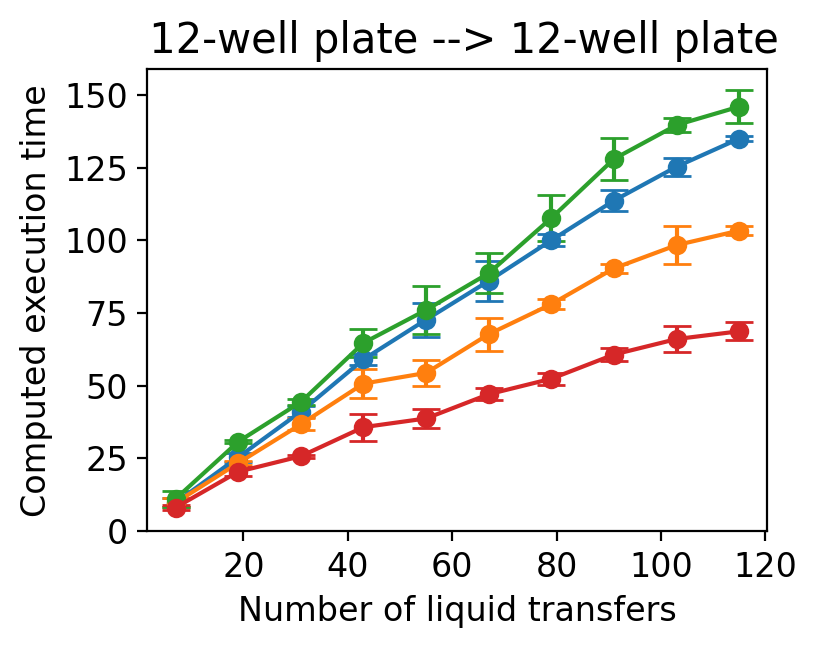

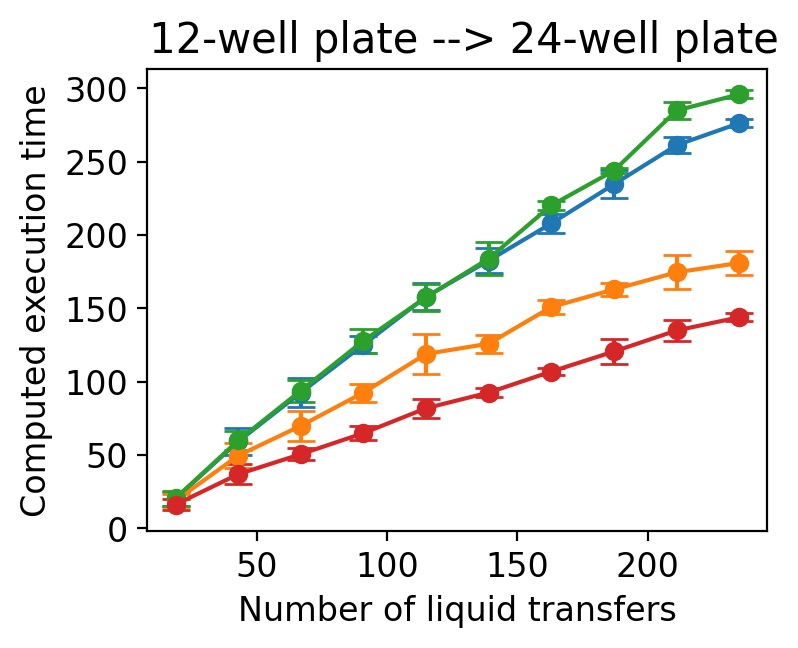

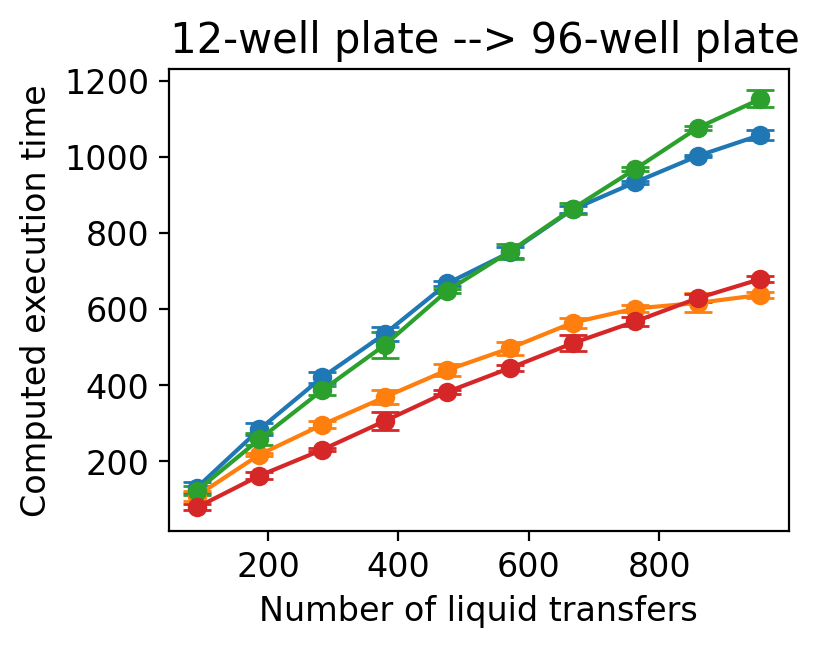

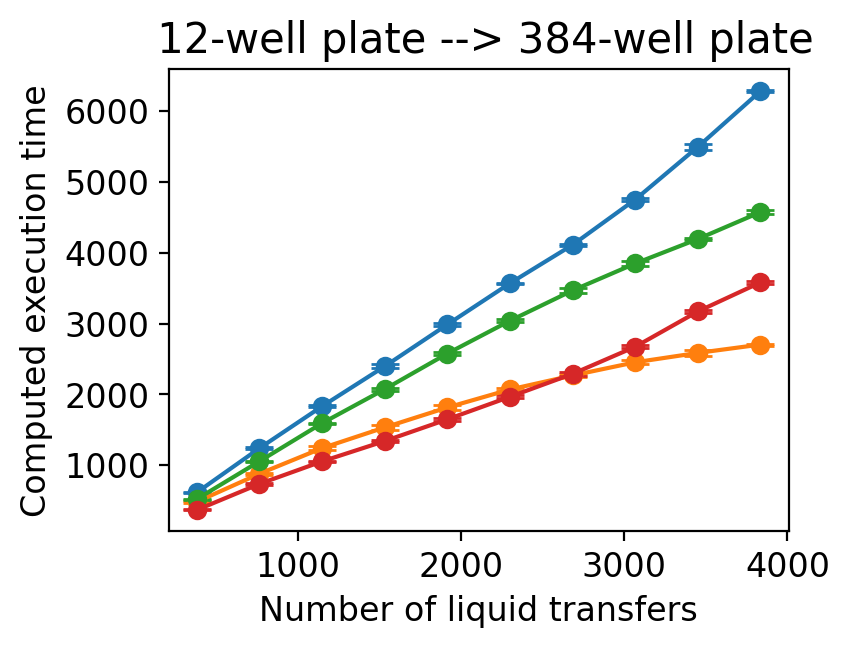

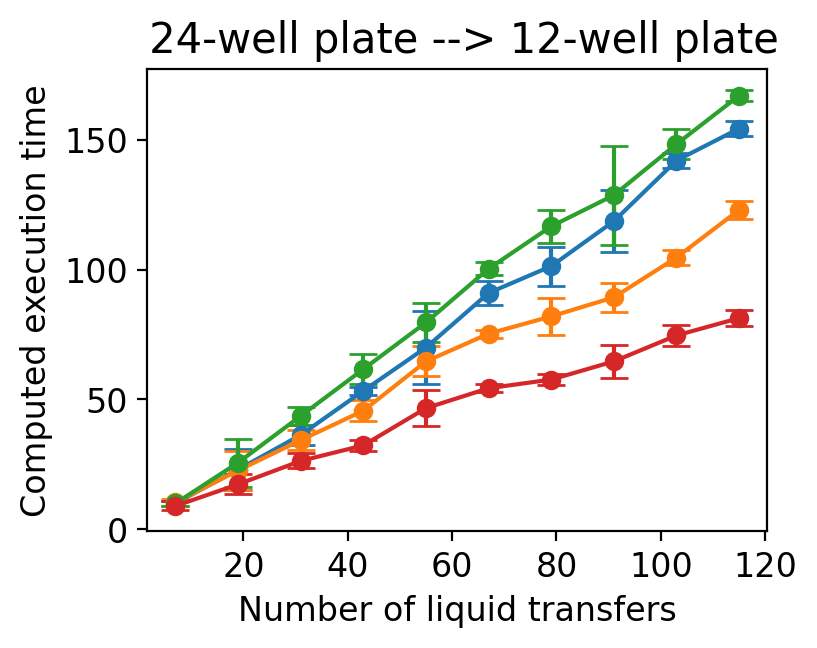

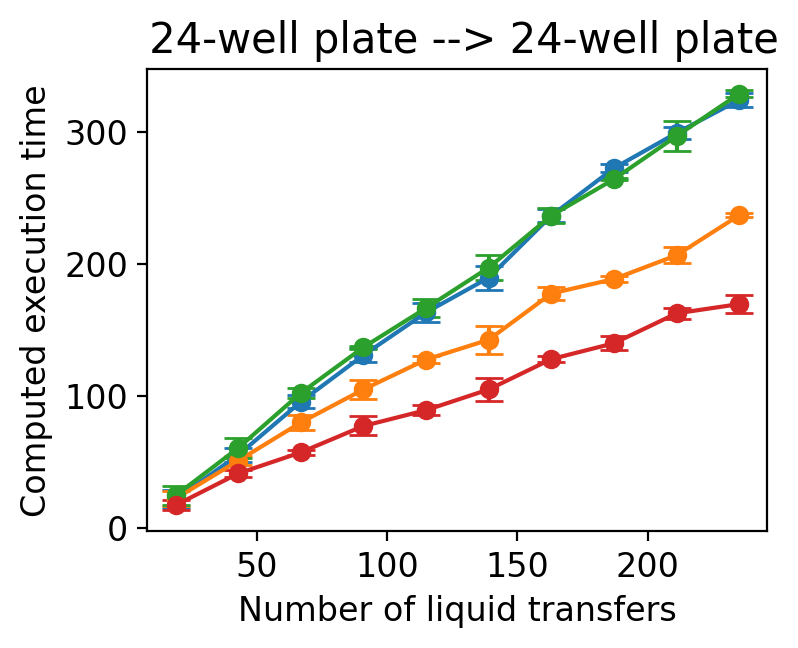

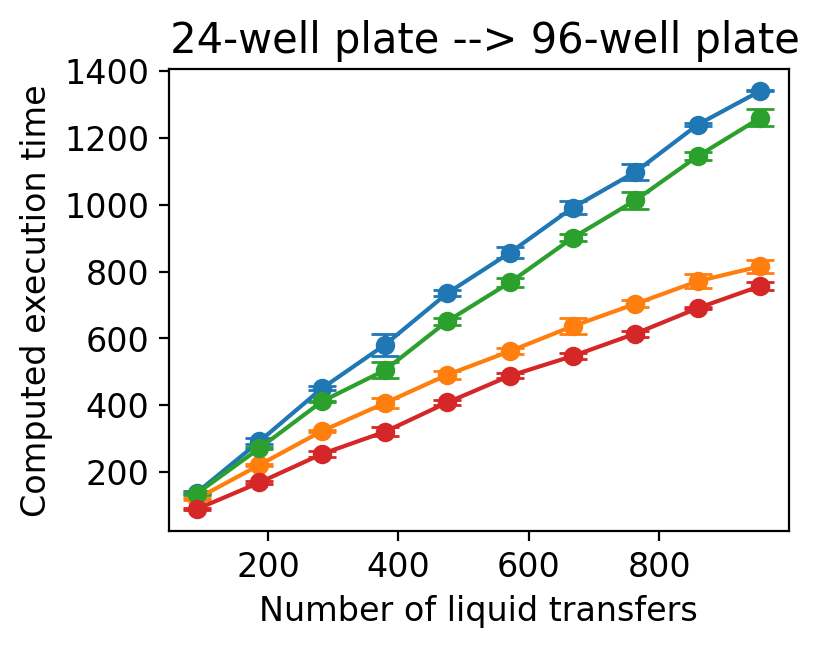

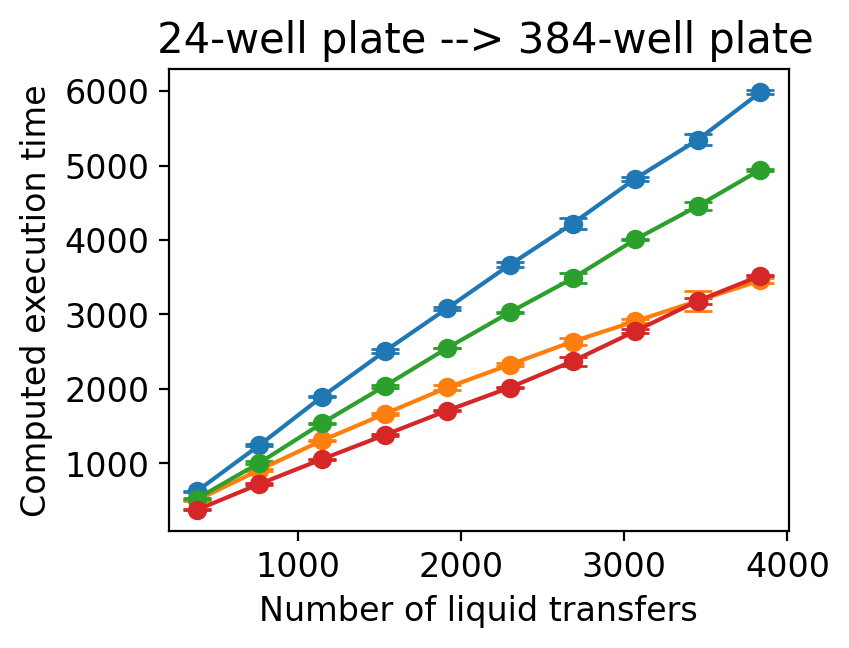

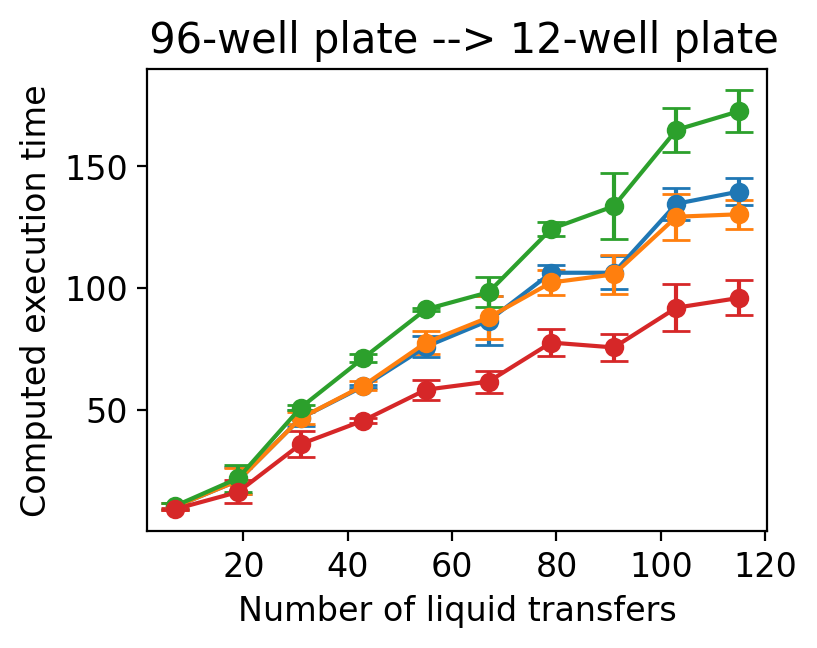

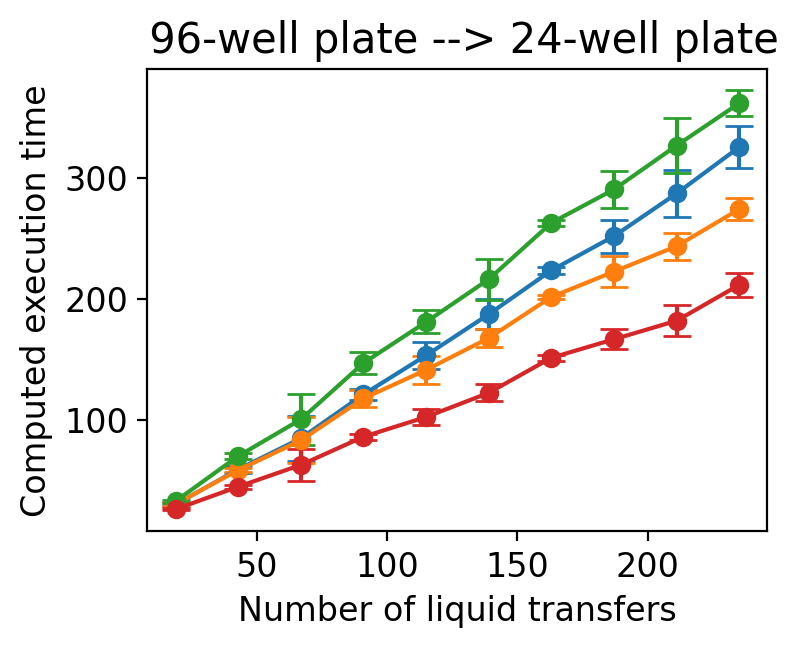

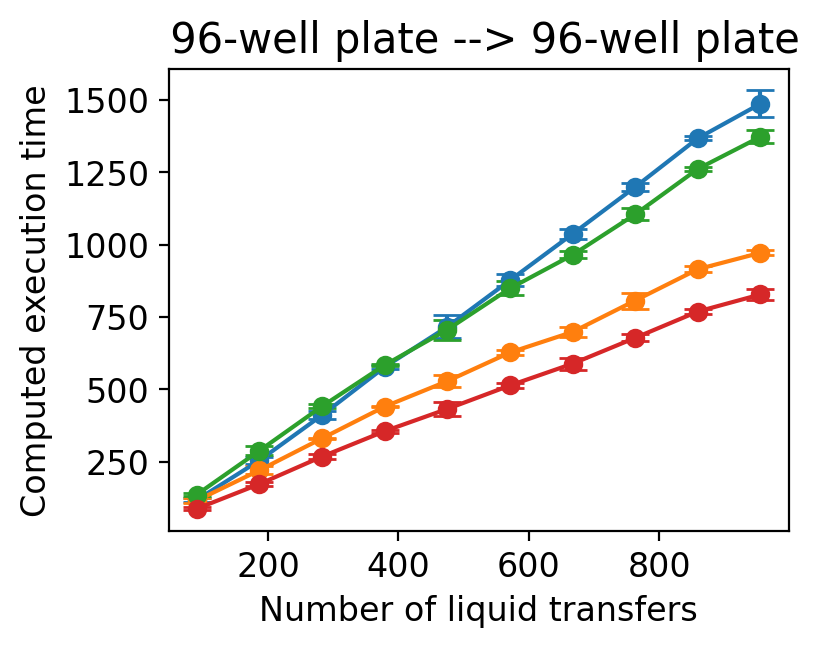

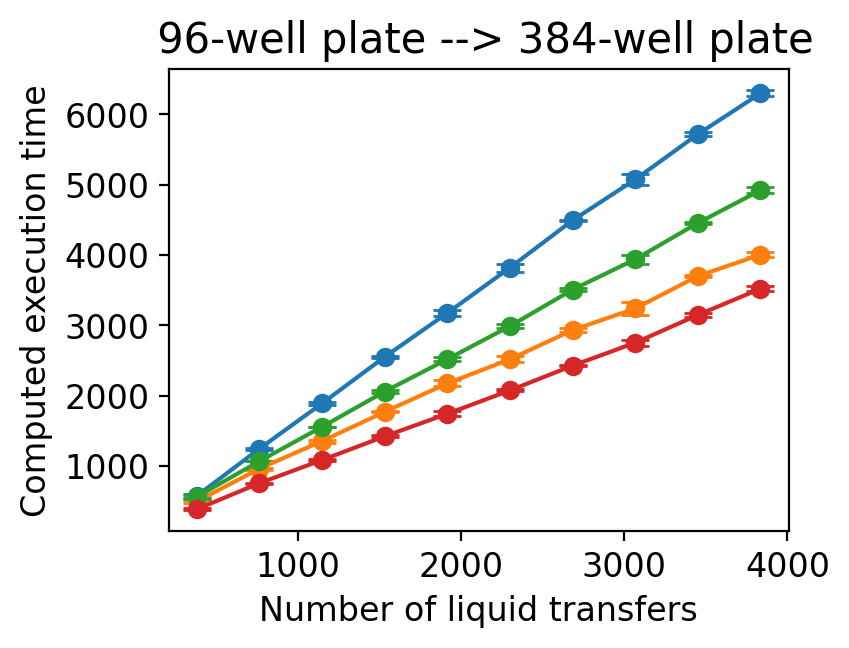

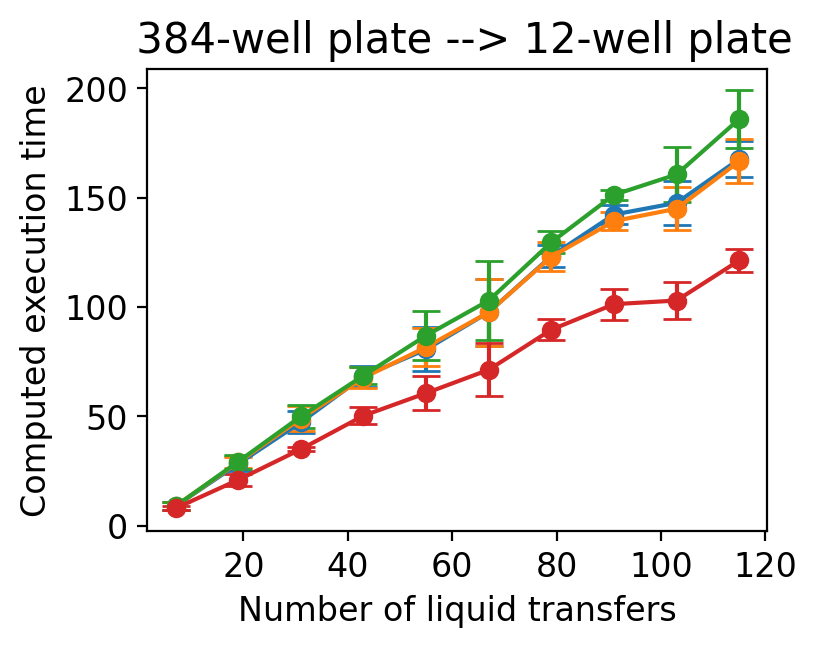

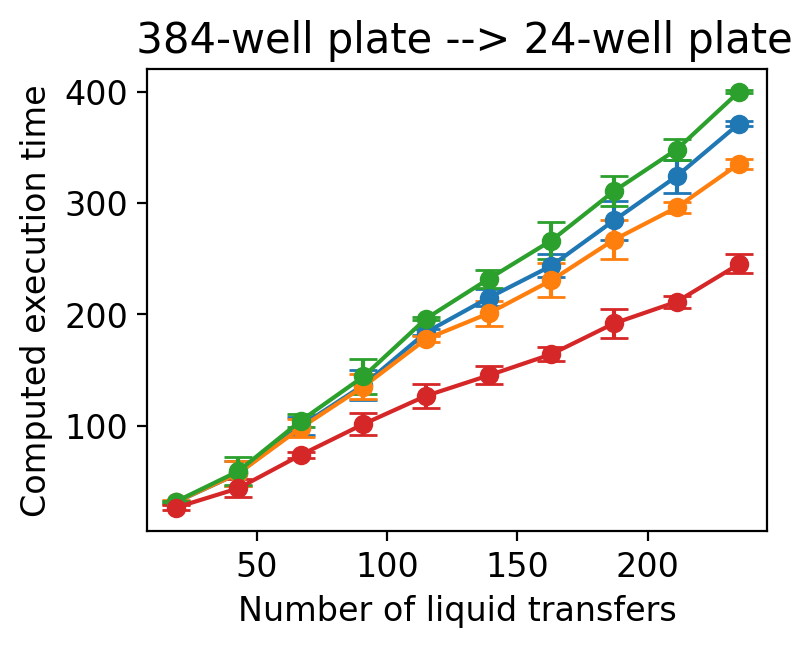

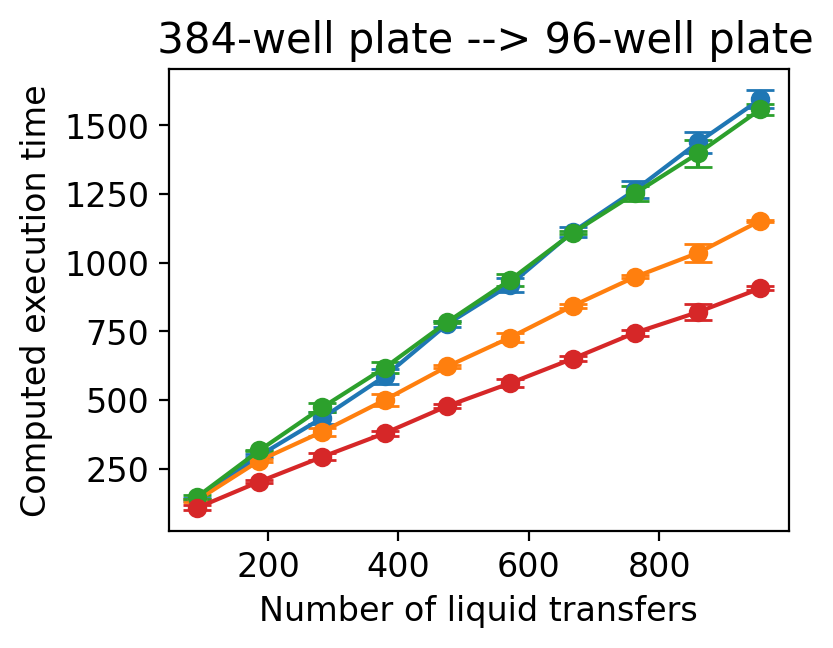

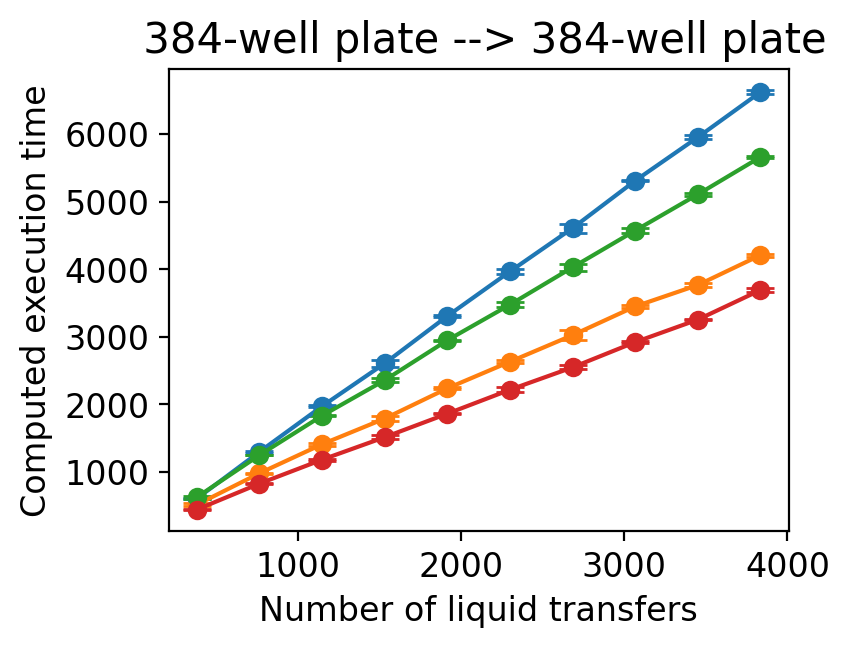

In [13]:
for labware_combination in labware_combinations:
    source = labware_combination[0]
    dest = labware_combination[1]
    df_choosen = df[(df['source_labware'] == source) & (df['dest_labware'] == dest)]
    # compute the mean and std of the unoptimized, rowwise, greedy and VRP
    df_choosen_mean = df_choosen.groupby(['num_samples']).mean().reset_index()
    df_choosen_std = df_choosen.groupby(['num_samples']).std().reset_index()
    # plot the results
    plt.figure(figsize=(4, 3),dpi=200,clear=True)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['unoptimized'], yerr=df_choosen_std['unoptimized'], label='row-major sorting', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['rowwise'], yerr=df_choosen_std['rowwise'], label='LAP', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['greedy'], yerr=df_choosen_std['greedy'], label='greedy', fmt='o-', capsize=5)
    plt.errorbar(df_choosen_mean['num_samples'], df_choosen_mean['VRP'], yerr=df_choosen_std['VRP'], label='CVRP', fmt='o-', capsize=5)
    plt.title(f' {source}-well plate --> {dest}-well plate', fontsize=15)
    plt.xlabel('Number of liquid transfers', fontsize=12)
    plt.ylabel('Computed execution time', fontsize=12)
    # tick labels size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.locator_params(nbins=7)
    #plt.legend()
    #plt.tight_layout()
    plt.show()

In [ ]:
np.random.seed(0)
df = pd.DataFrame(columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])
for labware_combination in range(1): 

    source_dim = 1536
    dest_dim = 1536
    print(f'source_dim={source_dim}, dest_dim={dest_dim}')
    for r in range(3):
        print('repeat:',r+1)
        stats = []
        for i in range(1, 11):

            num_candidates = dest_dim * i - 5
            num_candidates = int(num_candidates)
            print(f'num_candidates={num_candidates}')
            a = random_choose_candidate_2(source_dim,dest_dim,num_candidates)
            a[a>0] = 1
            jobs = np.argwhere(a)
            D_S = calculate_D(a.shape[0])
            D_D = calculate_D(a.shape[1])
            S, E = calculate_S_E(a)   
            # calculate distance matrix
            D_prime = calculate_D_prime(D_S,D_D, S, E)
            D_prime = add_depot(D_prime)
            # VRP solver
            VRP_distance, VRP_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time =60)
            print(f'VRP_distance: {VRP_distance}')
            # calculate the cost of the non-optimized sequence
            tasks = np.array(range(jobs.shape[0]))
            tasks = tasks+1
            # if tasks.shape[0] %8 != 0, pad with -1
            if tasks.shape[0] %8 != 0:
                tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
            unoptimized_seuqnece = tasks.reshape(-1, 8)
            t = calculate_T(unoptimized_seuqnece)
            d = D_prime[1:, 1:]
            non_optimized_distance = np.trace(np.dot(t.T, d))
            # change non_optimized_distance to integer
            non_optimized_distance = int(non_optimized_distance)
            print(f'non_optimized_distance: {non_optimized_distance}')
            
            # calculate the cost of the row-wise optimized sequence
            index_matrix = np.zeros((source_dim,dest_dim))
            for j in range(jobs.shape[0]):
                index_matrix[jobs[j, 0], jobs[j, 1]] = j+1
            row_wise_optimized_sequence = row_wise_optimization(index_matrix)
            if row_wise_optimized_sequence.shape[0] %8 != 0:
                row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
            t = calculate_T(row_wise_optimized_sequence)
            row_wise_optimized_distance = np.trace(np.dot(t.T, d))
            # change non_optimized_distance to integer
            row_wise_optimized_distance = int(row_wise_optimized_distance)
            print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

            # calculate the cost of the greedy optimized sequence
            greedy_optimized_sequence = greedy_scheduling(jobs, d)
            if greedy_optimized_sequence.shape[0] %8 != 0:
                greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
            greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
            t = calculate_T(greedy_optimized_sequence)
            greedy_optimized_distance = np.trace(np.dot(t.T, d))
            print(f'greedy_optimized_distance: {greedy_optimized_distance}')
            # append the results to the df
            stats.append([source_dim, dest_dim, num_candidates, r+1, non_optimized_distance, row_wise_optimized_distance, greedy_optimized_distance, VRP_distance])
        # convert the stats to the dataframe
        stats = pd.DataFrame(stats, columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'unoptimized','rowwise', 'greedy','VRP'])
        # append the stats to the df
        df = pd.concat([df, stats], ignore_index=True)
        print(df)


source_dim=1536, dest_dim=1536
repeat: 1
num_candidates=1531
VRP_distance: 1843
non_optimized_distance: 2661
row_wise_optimized_distance: 2056
greedy_optimized_distance: 2577.0
num_candidates=3067
VRP_distance: 3312
non_optimized_distance: 5358
row_wise_optimized_distance: 3816
greedy_optimized_distance: 5055.0
num_candidates=4603
VRP_distance: 4688
non_optimized_distance: 8048
row_wise_optimized_distance: 5452
greedy_optimized_distance: 7318.0
num_candidates=6139
VRP_distance: 6244
non_optimized_distance: 10541
row_wise_optimized_distance: 7038
greedy_optimized_distance: 9441.0
num_candidates=7675
VRP_distance: 7610
non_optimized_distance: 13145
row_wise_optimized_distance: 8523
greedy_optimized_distance: 11536.0
num_candidates=9211
VRP_distance: 8993
non_optimized_distance: 16037
row_wise_optimized_distance: 10243
greedy_optimized_distance: 13994.0
num_candidates=10747
VRP_distance: 10431
non_optimized_distance: 18692
row_wise_optimized_distance: 11898
greedy_optimized_distance: 1617

/tmp/ipykernel_677109/2356001948.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, stats], ignore_index=True)


VRP_distance: 1831
non_optimized_distance: 2652
row_wise_optimized_distance: 2058
greedy_optimized_distance: 2584.0
num_candidates=3067
VRP_distance: 3290
non_optimized_distance: 5356
row_wise_optimized_distance: 3837
greedy_optimized_distance: 5018.0
num_candidates=4603
VRP_distance: 4654
non_optimized_distance: 7920
row_wise_optimized_distance: 5375
greedy_optimized_distance: 7207.0
num_candidates=6139
VRP_distance: 6167
non_optimized_distance: 10582
row_wise_optimized_distance: 6939
greedy_optimized_distance: 9423.0
num_candidates=7675
VRP_distance: 7502
non_optimized_distance: 13190
row_wise_optimized_distance: 8543
greedy_optimized_distance: 11610.0
num_candidates=9211
VRP_distance: 8930
non_optimized_distance: 15971
row_wise_optimized_distance: 10255
greedy_optimized_distance: 13884.0
num_candidates=10747
VRP_distance: 10324
non_optimized_distance: 18542
row_wise_optimized_distance: 11639
greedy_optimized_distance: 15960.0
num_candidates=12283
VRP_distance: 11866
non_optimized_di